# Model

Our model begins with a Regression Classifier.

# Description

We attempt three models:

1. RandomForestRegressor
2. LinearRegression
3. XGBoost

In [1]:
import kagglehub
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

# Regression Classifier.
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

# Statsmodels.
import statsmodels.api as sm
import pandas as pd
import pickle

# XGBoost.
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

/Users/nathanlonghurst/Desktop/ACME/vol3-project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load dataset.
# Download latest version
path = kagglehub.dataset_download("lashagoch/life-expectancy-who-updated")
print("Path to dataset files:", path)

file = "Life-Expectancy-Data-Updated.csv"

data = pd.read_csv(path + "/" + file)

# FEATURE ENGINEERING
# take log of GDP per capita
data["GDP_per_capita"] = np.log10(data["GDP_per_capita"])

# take average vaccination percentage
data["Vaccination_score"] = (data["Hepatitis_B"] + data["Polio"] + data["Diphtheria"])/3

# Compute Lifestyle Index
BMI_score = 1*(data["BMI"] <= 30)*(data["BMI"] > 25) + 2*(data["BMI"] > 30)
Alcohol_score = 1*(data["Alcohol_consumption"] <= 9.722)*(data["Alcohol_consumption"] > 3.241) + 2*(data["Alcohol_consumption"] > 9.722)
data["Lifestyle_index"] = BMI_score + Alcohol_score

X = data[['Alcohol_consumption', 'Hepatitis_B', 'Measles',
       'BMI', 'Polio', 'Diphtheria', 'Incidents_HIV', 'GDP_per_capita',
       'Population_mln', 'Thinness_ten_nineteen_years',
       'Thinness_five_nine_years', 'Schooling', 'Economy_status_Developed', 'Vaccination_score', 'Lifestyle_index']]

y = data['Life_expectancy']

# Split data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Path to dataset files: /Users/nathanlonghurst/.cache/kagglehub/datasets/lashagoch/life-expectancy-who-updated/versions/1


In [3]:
lin_regress_aic = sm.load("LinearRegressionAIC.pickle")
lin_regress_bic = sm.load("LinearRegressionBIC.pickle")
with open('RandomForestRegressor.pkl', 'rb') as f:
    random_forest = pickle.load(f)
with open('XGBoost.pkl', 'rb') as f:
    xgboost = pickle.load(f)

In [25]:
aic_features = ['Alcohol_consumption', 'Hepatitis_B', 'BMI', 'Polio', 'Diphtheria', 'Incidents_HIV', 'GDP_per_capita', 'Population_mln', 'Thinness_ten_nineteen_years', 'Thinness_five_nine_years', 'Schooling', 'Economy_status_Developed']
bic_features = ['Alcohol_consumption', 'BMI', 'Polio', 'Incidents_HIV', 'GDP_per_capita', 'Population_mln', 'Schooling', 'Economy_status_Developed']
reg_features = ['Alcohol_consumption', 'Hepatitis_B', 'Measles',
       'BMI', 'Polio', 'Diphtheria', 'Incidents_HIV', 'GDP_per_capita',
       'Population_mln', 'Thinness_ten_nineteen_years',
       'Thinness_five_nine_years', 'Schooling', 'Economy_status_Developed', 'Vaccination_score', 'Lifestyle_index']

In [123]:
def plot_worst_increase_2014(col, shift_val, num_predict, ascending=False):
    data_2014 = data[data["Year"] == 2014]
    expectancy_2014 = data_2014.sort_values(by=col, ascending=ascending)
    aic_predictions = []
    bic_predictions = []
    random_forest_predictions = []
    xgboost_predictions = []

    # amount to shift hiv scores to

    # Get the original data
    original_expectancy = expectancy_2014["Life_expectancy"].to_numpy()[:num_predict]
    original_col_val = expectancy_2014[col].to_numpy()[:num_predict]

    # shift the value of interest to get new prediction
    expectancy_2014[col] = expectancy_2014[col] + shift_val

    # get predictions
    for idx in range(num_predict):
        aic_data = expectancy_2014.iloc[idx][aic_features].to_numpy()
        bic_data = expectancy_2014.iloc[idx][bic_features].to_numpy()
        reg_data = np.expand_dims(expectancy_2014.iloc[idx][reg_features].to_numpy(), axis=0)

        aic_predictions.append(lin_regress_aic.predict(aic_data)[0])
        bic_predictions.append(lin_regress_bic.predict(bic_data)[0])
        random_forest_predictions.append(random_forest.predict(reg_data)[0])
        xgboost_predictions.append(xgboost.predict(reg_data)[0])

    def plot_increase(predictions):
        increases_avg = []
        for prediction_set, label in zip(predictions, ["aic", "bic", "random forest", "xgboost"]):
            increase = np.array(prediction_set) - original_expectancy
            increases_avg.append(np.mean(increase))
            sorted = original_col_val.argsort()
            plt.scatter(original_col_val[sorted], increase[sorted], label=label)
        
        plt.ylabel("Change in Life Expectancy")
        plt.xlabel(f"Original {col}")
        plt.title(f"Predicting Life Expectancy with {num_predict} worst countries here with {shift_val} shift for {col}")
        plt.legend()
        plt.show()
        return increases_avg

    return plot_increase([aic_predictions, bic_predictions, random_forest_predictions, xgboost_predictions])


/Users/nathanlonghurst/Desktop/ACME/vol3-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/nathanlonghurst/Desktop/ACME/vol3-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/nathanlonghurst/Desktop/ACME/vol3-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/nathanlonghurst/Desktop/ACME/vol3-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/nathanlonghurst/Desktop/ACME/

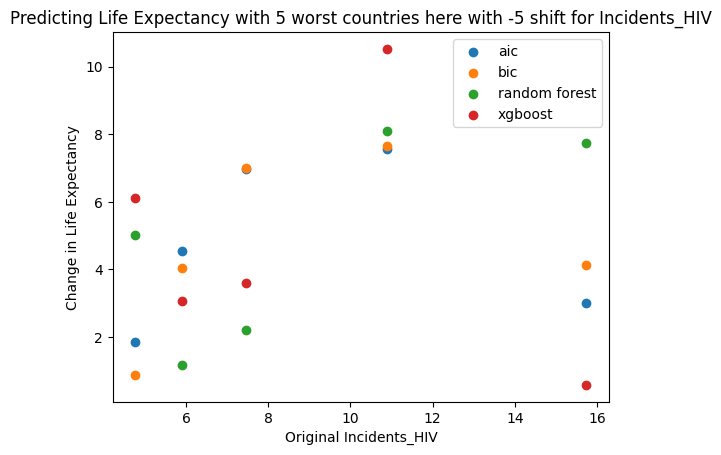

In [124]:
avg_increase = plot_worst_increase_2014("Incidents_HIV", -5, 5)

/Users/nathanlonghurst/Desktop/ACME/vol3-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/nathanlonghurst/Desktop/ACME/vol3-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/nathanlonghurst/Desktop/ACME/vol3-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/nathanlonghurst/Desktop/ACME/vol3-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/nathanlonghurst/Desktop/ACME/

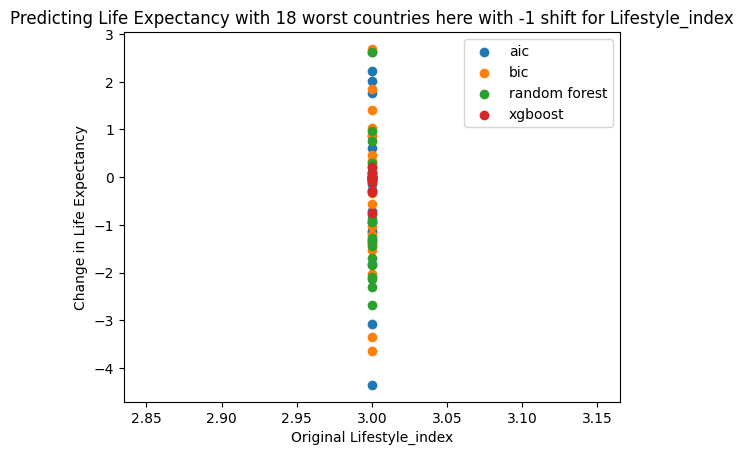

In [128]:
avg_increase = plot_worst_increase_2014("Lifestyle_index", -1, 18)

In [130]:
print(f"average increase for the 4 predictors {avg_increase}")

average increase for the 4 predictors [np.float64(-0.3030386796180685), np.float64(-0.48131648069597016), np.float64(-0.7646162723517236), np.float64(-0.0745051913791212)]
